### 1. One Solution

In [ ]:
import sys

import numpy as np
import pandas as pd
from timeit import default_timer as timer


def get_rank_sum(network: pd.DataFrame, rank_df: pd.DataFrame):
    """
    :param network: Causal-priors network in pd.DataFrame format
    :param rank_df:  Differential expression data in pd.DataFrame format.
    Also contains rank and reverse_rank columns
    :return: Actual rank-sum of genes in de dataframe
    """
    # find the maximum number of targets for a Symbol
    max_targets = max(network['Symbols'].value_counts().to_dict().values())

    # Create a column named is_upregulated in network dataframe, 1 is upregulated and -1 is downregulated
    network['is_upregulated'] = np.where(network['action'] == 'upregulates-expression', 1, -1)
    # Delete action column from network dataframe
    network.drop('action', axis=1, inplace=True)

    # Find the positive and negative ranks of targetSymbols
    network['rank'] = network['targetSymbol'].apply(lambda x: rank_df[rank_df['Symbols'] == x]['rank'].values[0])
    network['reverse_rank'] = network['targetSymbol'].apply(
        lambda x: rank_df[rank_df['Symbols'] == x]['reverse_rank'].values[0])

    # Calculate the actual rank sum of each Symbol for positive and negative ranks
    actual_rank_sum_df = network.groupby('Symbols').apply(
        lambda x: x[x['is_upregulated'] == 1]['rank'].sum() + x[x['is_upregulated'] == -1][
            'reverse_rank'].sum()).reset_index(name='actual_rank_sum')
    actual_rank_sum_df['actual_negative_rank_sum'] = network.groupby('Symbols').apply(
        lambda x: x[x['is_upregulated'] == 1]['reverse_rank'].sum() + x[x['is_upregulated'] == -1][
            'rank'].sum()).reset_index(name='actual_negative_rank_sum')['actual_negative_rank_sum']

    # Create a new dataframe with key: Symbols and value: List of 1's and -1's
    target_counts_df = network.groupby('Symbols')['is_upregulated'].apply(list).reset_index(name='count')

    # Merge actual_rank_sum_df dataframe with target_counts_df dataframe on Symbols column
    target_counts_df = pd.merge(target_counts_df, actual_rank_sum_df, on='Symbols')
    # Clear actual_rank_sum_df dataframe from memory
    del actual_rank_sum_df

    # Choose minimum between actual_rank_sum and actual_negative_rank_sum as actual_min_rank_sum
    target_counts_df['actual_min_rank_sum'] = target_counts_df.apply(
        lambda x: min(x['actual_rank_sum'], x['actual_negative_rank_sum']), axis=1)
    # Drop actual_rank_sum and actual_negative_rank_sum columns from target_counts_df dataframe
    target_counts_df.drop(['actual_rank_sum', 'actual_negative_rank_sum'], axis=1, inplace=True)

    # Remove the rows where length of count is less than 3
    target_counts_df = target_counts_df[target_counts_df['count'].apply(lambda x: len(x)) >= 3]

    # Create a column named up_down_tuple in target_counts_df df, (x, y) x count of 1's and y count of -1's
    target_counts_df['up_down_tuple'] = target_counts_df['count'].apply(lambda x: (x.count(1), x.count(-1)))

    # Find the max rank from rank_df dataframe
    max_rank = rank_df['rank'].max()

    # Add a new column in target_counts_df to store how many times the rank sum is less than the actual rank sum
    target_counts_df['rank_sum_less_than_actual'] = 0

    # Find the unique values in up_down_tuple column and store it in a pandas dataframe
    updown_df = pd.DataFrame(target_counts_df['up_down_tuple'].unique(), columns=['up_down_tuple'])

    # Convert up_down_tuple into a NumPy array for faster operations
    up_down_tuple_list = updown_df['up_down_tuple'].tolist()

    rand_iter = 10_000

    # Initialize the array to store results
    results_array = np.zeros((len(up_down_tuple_list), rand_iter))

    for i in range(rand_iter):
        # Pick max_targets random numbers from 0 to max_rank+1
        randomly_drawn_list = np.random.randint(low=0, high=max_rank + 1, size=max_targets)

        # Create reverse randomly_drawn_list from rank_df dataframe
        reverse_randomly_drawn_list = max_rank - randomly_drawn_list

        # Create a new df
        df = np.array([sum(randomly_drawn_list[:x[0]]) + sum(reverse_randomly_drawn_list[x[0]:x[0] + x[1]]) for x in
                       up_down_tuple_list])

        # Create a new column reverse_rank in df and store reverse rank sum
        rev_df = np.array([sum(reverse_randomly_drawn_list[:x[0]]) + sum(randomly_drawn_list[x[0]:x[0] + x[1]]) for x in
                           up_down_tuple_list])

        # Find the minimum between df and rev_df
        min_df = np.minimum(df, rev_df)

        # Store the result in the results_array
        results_array[:, i] = min_df

    # Concatenate updown_df and df and store it in updown_df
    updown_df = pd.concat([updown_df, pd.DataFrame(results_array)], axis=1)

    # New dataframe using up_down_tuple of updown_df and another column rank_sum_list which contains
    # list of rank sums for each up_down_tuple
    rank_sum_df = updown_df[['up_down_tuple']].copy()
    rank_sum_df['rank_sum_list'] = updown_df.drop('up_down_tuple', axis=1).values.tolist()

    # For up_down_tuple in target_counts_df, find the rank_sum_list from rank_sum_df and store it in a new column
    target_counts_df['rank_sum_list'] = target_counts_df['up_down_tuple'].apply(
        lambda x: rank_sum_df[rank_sum_df['up_down_tuple'] == x]['rank_sum_list'].values[0])

    # Count the numbers in rank_sum_list which are less than actual_min_rank_sum and store it in a new column
    target_counts_df['rank_sum_less_than_actual'] = target_counts_df.apply(
        lambda x: len([i for i in x['rank_sum_list'] if i < x['actual_min_rank_sum']]), axis=1)

    # Calculate the p-value
    target_counts_df['p-value'] = target_counts_df['rank_sum_less_than_actual'].apply(
        lambda x: (x + 1) / rand_iter if x == 0 else x / rand_iter)

    # Drop the columns which are not required
    target_counts_df.drop(['rank_sum_list'], axis=1, inplace=True)

    # Save the dataframe to a csv file
    target_counts_df.to_csv('../output/output_file.csv', index=False)


def main(cp_file: str, de_file: str):
    """
    :param cp_file: File path of causal-priors file
    :param de_file: File path of differential-exp file
    :return:
    """
    if cp_file is None or de_file is None:
        print('Please provide causal-priors and differential-exp file path')
        sys.exit(1)

    if not isinstance(cp_file, str) or not isinstance(de_file, str):
        print('Please provide causal-priors and differential-exp file path as string')
        sys.exit(1)

    # Try except block to handle file not found error
    try:
        cp = pd.read_csv(cp_file, sep='\t', header=None)
        cp.columns = ['Symbols', 'action', 'targetSymbol', 'reference', 'residual']

        # remove all columns except upregulates-expression and downregulates-expression
        cp = cp[cp['action'].isin(['upregulates-expression', 'downregulates-expression'])]
        # reset index
        cp = cp.reset_index(drop=True)

        # delete reference and residual columns
        cp = cp.drop(['reference', 'residual'], axis=1)

        de = pd.read_csv(de_file, sep='\t')

        # Create a new column named updown based on positive
        # and negative values of SignedP column of de dataframe
        de['updown'] = np.where(de['SignedP'] > 0, '1', '-1')

        # Sort SignedP column in ascending order if updown column is 1
        # and sort absolute values of SignedP column in ascending order if updown column is -1
        de = de.sort_values(by=['updown', 'SignedP'], ascending=[False, True])

        # Remove rows of cp dataframe if targetSymbol is not present in Symbols column of rank_df dataframe
        cp = cp[cp['targetSymbol'].isin(de['Symbols'])]
        # Reset index
        cp = cp.reset_index(drop=True)

        # Add new column named rank to de dataframe
        de['rank'] = np.arange(len(de))

        # Add reverse_rank column to de dataframe
        de['reverse_rank'] = de['rank'].max() - de['rank']

        # Sort Symbols column in ascending order of cp dataframe
        cp = cp.sort_values(by=['Symbols'], ascending=True, ignore_index=True)

        get_rank_sum(cp, de)

    except FileNotFoundError:
        print('File not found: ', cp_file)
        sys.exit(1)

    except Exception as e:
        print(e)
        sys.exit(1)


if __name__ == '__main__':
    priors_file = '../data/causal-priors.txt'
    diff_file = '../data/differential-exp.tsv'  # For 50,000 iterations it takes 14 seconds.
    # It has 415 ranks
    # diff_file = '../data/rslp_vs_lum.tsv'  # For 50,000 iterations it takes 28 seconds.
    # It has 1187 ranks
    # diff_file = '../data/basal_vs_lum.tsv' # For 50,000 iterations it takes 14 seconds.
    # It has 460 ranks

    # main(priors_file, diff_file)

    times_takes = []
    for i in range(0, 10):
        start = timer()
        main(priors_file, diff_file)
        end = timer()
        times_takes.append(end - start)

    print(times_takes)
    print("Average Time: ", np.mean(times_takes))


### 2. Very similar the previous solution, Only difference is that I used single loop to find min rank sum

In [2]:
import sys

import numpy as np
import pandas as pd
from timeit import default_timer as timer


def get_rank_sum(network: pd.DataFrame, rank_df: pd.DataFrame):
    """
    :param network: Causal-priors network in pd.DataFrame format
    :param rank_df:  Differential expression data in pd.DataFrame format.
    Also contains rank and reverse_rank columns
    :return: Actual rank-sum of genes in de dataframe
    """
    # find the maximum number of targets for a Symbol
    max_targets = max(network['Symbols'].value_counts().to_dict().values())

    # Create a column named is_upregulated in network dataframe, 1 is upregulated and -1 is downregulated
    network['is_upregulated'] = np.where(network['action'] == 'upregulates-expression', 1, -1)
    # Delete action column from network dataframe
    network.drop('action', axis=1, inplace=True)

    # Find the positive and negative ranks of targetSymbols
    network['rank'] = network['targetSymbol'].apply(lambda x: rank_df[rank_df['Symbols'] == x]['rank'].values[0])
    network['reverse_rank'] = network['targetSymbol'].apply(
        lambda x: rank_df[rank_df['Symbols'] == x]['reverse_rank'].values[0])

    # Calculate the actual rank sum of each Symbol for positive and negative ranks
    actual_rank_sum_df = network.groupby('Symbols').apply(
        lambda x: x[x['is_upregulated'] == 1]['rank'].sum() + x[x['is_upregulated'] == -1][
            'reverse_rank'].sum()).reset_index(name='actual_rank_sum')
    actual_rank_sum_df['actual_negative_rank_sum'] = network.groupby('Symbols').apply(
        lambda x: x[x['is_upregulated'] == 1]['reverse_rank'].sum() + x[x['is_upregulated'] == -1][
            'rank'].sum()).reset_index(name='actual_negative_rank_sum')['actual_negative_rank_sum']

    # Create a new dataframe with key: Symbols and value: List of 1's and -1's
    target_counts_df = network.groupby('Symbols')['is_upregulated'].apply(list).reset_index(name='count')

    # Merge actual_rank_sum_df dataframe with target_counts_df dataframe on Symbols column
    target_counts_df = pd.merge(target_counts_df, actual_rank_sum_df, on='Symbols')
    # Clear actual_rank_sum_df dataframe from memory
    del actual_rank_sum_df

    # Choose minimum between actual_rank_sum and actual_negative_rank_sum as actual_min_rank_sum
    target_counts_df['actual_min_rank_sum'] = target_counts_df.apply(
        lambda x: min(x['actual_rank_sum'], x['actual_negative_rank_sum']), axis=1)
    # Find which one is minimum and store it in IsPosNeg column
    target_counts_df['IsPosNeg'] = target_counts_df.apply(
        lambda x: 'Positive' if x['actual_rank_sum'] < x['actual_negative_rank_sum'] else 'Negative',
        axis=1)
    # Drop actual_rank_sum and actual_negative_rank_sum columns from target_counts_df dataframe
    target_counts_df.drop(['actual_rank_sum', 'actual_negative_rank_sum'], axis=1, inplace=True)

    # Remove the rows where length of count is less than 3
    target_counts_df = target_counts_df[target_counts_df['count'].apply(lambda x: len(x)) >= 3]

    # Create a column named up_down_tuple in target_counts_df df, (x, y) x count of 1's and y count of -1's
    target_counts_df['up_down_tuple'] = target_counts_df['count'].apply(lambda x: (x.count(1), x.count(-1)))

    # Find the max rank from rank_df dataframe
    max_rank = rank_df['rank'].max()

    # Add a new column in target_counts_df to store how many times the rank sum is less than the actual rank sum
    target_counts_df['rank_sum_less_than_actual'] = 0

    # Find the unique values in up_down_tuple column and store it in a pandas dataframe
    updown_df = pd.DataFrame(target_counts_df['up_down_tuple'].unique(), columns=['up_down_tuple'])

    # Convert up_down_tuple into a NumPy array for faster operations
    up_down_tuple_list = updown_df['up_down_tuple'].tolist()

    rand_iter = 2_000

    # Initialize the array to store results
    results_array = np.zeros((len(up_down_tuple_list), rand_iter))

    for i in range(rand_iter):
        # Pick max_targets random numbers from 0 to max_rank+1
        randomly_drawn_list = np.random.randint(low=0, high=max_rank + 1, size=max_targets)

        # Create reverse randomly_drawn_list from rank_df dataframe
        reverse_randomly_drawn_list = max_rank - randomly_drawn_list

        min_df = np.array(
            [
                min(
                    sum(randomly_drawn_list[:x[0]]) + sum(reverse_randomly_drawn_list[x[0]:x[0] + x[1]]),
                    sum(reverse_randomly_drawn_list[:x[0]]) + sum(randomly_drawn_list[x[0]:x[0] + x[1]])
                )
                for x in up_down_tuple_list
            ]
        )

        # Store the result in the results_array
        results_array[:, i] = min_df

    # Concatenate updown_df and df and store it in updown_df
    updown_df = pd.concat([updown_df, pd.DataFrame(results_array)], axis=1)

    # New dataframe using up_down_tuple of updown_df and another column rank_sum_list which contains
    # list of rank sums for each up_down_tuple
    rank_sum_df = updown_df[['up_down_tuple']].copy()
    rank_sum_df['rank_sum_list'] = updown_df.drop('up_down_tuple', axis=1).values.tolist()

    # For up_down_tuple in target_counts_df, find the rank_sum_list from rank_sum_df and store it in a new column
    target_counts_df['rank_sum_list'] = target_counts_df['up_down_tuple'].apply(
        lambda x: rank_sum_df[rank_sum_df['up_down_tuple'] == x]['rank_sum_list'].values[0])

    # Count the numbers in rank_sum_list which are less than actual_min_rank_sum and store it in a new column
    target_counts_df['rank_sum_less_than_actual'] = target_counts_df.apply(
        lambda x: len([i for i in x['rank_sum_list'] if i < x['actual_min_rank_sum']]), axis=1)

    # Calculate the p-value
    target_counts_df['p-value'] = target_counts_df['rank_sum_less_than_actual'].apply(
        lambda x: (x + 1) / rand_iter if x == 0 else x / rand_iter)

    # Drop the columns which are not required
    target_counts_df.drop(['rank_sum_list'], axis=1, inplace=True)

    # Save the dataframe to a csv file
    target_counts_df.to_csv('../output/output_file.csv', index=False)


def main(cp_file: str, de_file: str):
    """
    :param cp_file: File path of causal-priors file
    :param de_file: File path of differential-exp file
    :return:
    """
    if cp_file is None or de_file is None:
        print('Please provide causal-priors and differential-exp file path')
        sys.exit(1)

    if not isinstance(cp_file, str) or not isinstance(de_file, str):
        print('Please provide causal-priors and differential-exp file path as string')
        sys.exit(1)

    # Try except block to handle file not found error
    try:
        cp = pd.read_csv(cp_file, sep='\t', header=None)
        cp.columns = ['Symbols', 'action', 'targetSymbol', 'reference', 'residual']

        # remove all columns except upregulates-expression and downregulates-expression
        cp = cp[cp['action'].isin(['upregulates-expression', 'downregulates-expression'])]
        # reset index
        cp = cp.reset_index(drop=True)

        # delete reference and residual columns
        cp = cp.drop(['reference', 'residual'], axis=1)

        de = pd.read_csv(de_file, sep='\t')

        # Create a new column named updown based on positive
        # and negative values of SignedP column of de dataframe
        de['updown'] = np.where(de['SignedP'] > 0, '1', '-1')

        # Sort SignedP column in ascending order if updown column is 1
        # and sort absolute values of SignedP column in ascending order if updown column is -1
        de = de.sort_values(by=['updown', 'SignedP'], ascending=[False, True])

        # Remove rows of cp dataframe if targetSymbol is not present in Symbols column of rank_df dataframe
        cp = cp[cp['targetSymbol'].isin(de['Symbols'])]
        # Reset index
        cp = cp.reset_index(drop=True)

        # Add new column named rank to de dataframe
        de['rank'] = np.arange(len(de))

        # Add reverse_rank column to de dataframe
        de['reverse_rank'] = de['rank'].max() - de['rank']

        # Sort Symbols column in ascending order of cp dataframe
        cp = cp.sort_values(by=['Symbols'], ascending=True, ignore_index=True)

        get_rank_sum(cp, de)

    except FileNotFoundError:
        print('File not found: ', cp_file)
        sys.exit(1)

    except Exception as e:
        print(e)
        sys.exit(1)


if __name__ == '__main__':
    priors_file = '../data/causal-priors.txt'
    diff_file = '../data/differential-exp.tsv'  # For 50,000 iterations it takes 14 seconds.
    # It has 415 ranks
    # diff_file = '../data/rslp_vs_lum.tsv' # For 50,000 iterations it takes 28 seconds.
    # It has 1187 ranks
    # diff_file = '../data/basal_vs_lum.tsv' # For 50,000 iterations it takes 14 seconds.
    # It has 460 ranks

    times_takes = []
    for i in range(0, 5):
        start = timer()
        main(priors_file, diff_file)
        end = timer()
        times_takes.append(end - start)

    print(times_takes)
    print("Average Time: ", np.mean(times_takes))


[2.027778893010691, 1.8819898220244795, 1.8718398108612746, 1.8752486209850758, 1.8878434840589762]
Average Time:  1.9089401261880994


### 3. Testing solution

In [1]:
import sys

import numpy as np
import pandas as pd
from timeit import default_timer as timer


def get_rank_sum(network: pd.DataFrame, rank_df: pd.DataFrame):
    """
    :param network: Causal-priors network in pd.DataFrame format
    :param rank_df:  Differential expression data in pd.DataFrame format.
    Also contains rank and reverse_rank columns
    :return: Actual rank-sum of genes in de dataframe
    """
    # find the maximum number of targets for a Symbol
    max_targets = max(network['Symbols'].value_counts().to_dict().values())

    # Create a column named is_upregulated in network dataframe, 1 is upregulated and -1 is downregulated
    network['is_upregulated'] = np.where(network['action'] == 'upregulates-expression', 1, -1)
    # Delete action column from network dataframe
    network.drop('action', axis=1, inplace=True)

    # Find the positive and negative ranks of targetSymbols
    network['rank'] = network['targetSymbol'].apply(lambda x: rank_df[rank_df['Symbols'] == x]['rank'].values[0])
    network['reverse_rank'] = network['targetSymbol'].apply(
        lambda x: rank_df[rank_df['Symbols'] == x]['reverse_rank'].values[0])

    # Calculate the actual rank sum of each Symbol for positive and negative ranks
    actual_rank_sum_df = network.groupby('Symbols').apply(
        lambda x: x[x['is_upregulated'] == 1]['rank'].sum() + x[x['is_upregulated'] == -1][
            'reverse_rank'].sum()).reset_index(name='actual_rank_sum')
    actual_rank_sum_df['actual_negative_rank_sum'] = network.groupby('Symbols').apply(
        lambda x: x[x['is_upregulated'] == 1]['reverse_rank'].sum() + x[x['is_upregulated'] == -1][
            'rank'].sum()).reset_index(name='actual_negative_rank_sum')['actual_negative_rank_sum']

    # Create a new dataframe with key: Symbols and value: List of 1's and -1's
    target_counts_df = network.groupby('Symbols')['is_upregulated'].apply(list).reset_index(name='count')

    # Merge actual_rank_sum_df dataframe with target_counts_df dataframe on Symbols column
    target_counts_df = pd.merge(target_counts_df, actual_rank_sum_df, on='Symbols')
    # Clear actual_rank_sum_df dataframe from memory
    del actual_rank_sum_df

    # Choose minimum between actual_rank_sum and actual_negative_rank_sum as actual_min_rank_sum
    target_counts_df['actual_min_rank_sum'] = target_counts_df.apply(
        lambda x: min(x['actual_rank_sum'], x['actual_negative_rank_sum']), axis=1)
    # Find which one is minimum and store it in IsPosNeg column
    target_counts_df['IsPosNeg'] = target_counts_df.apply(
        lambda x: 'Positive' if x['actual_rank_sum'] < x['actual_negative_rank_sum'] else 'Negative',
        axis=1)
    # Drop actual_rank_sum and actual_negative_rank_sum columns from target_counts_df dataframe
    target_counts_df.drop(['actual_rank_sum', 'actual_negative_rank_sum'], axis=1, inplace=True)

    # Remove the rows where length of count is less than 3
    target_counts_df = target_counts_df[target_counts_df['count'].apply(lambda x: len(x)) >= 3]

    # Create a column named up_down_tuple in target_counts_df df, (x, y) x count of 1's and y count of -1's
    target_counts_df['up_down_tuple'] = target_counts_df['count'].apply(lambda x: (x.count(1), x.count(-1)))

    # Find the max rank from rank_df dataframe
    max_rank = rank_df['rank'].max()

    # Add a new column in target_counts_df to store how many times the rank sum is less than the actual rank sum
    target_counts_df['rank_sum_less_than_actual'] = 0

    # Find the unique values in up_down_tuple column and store it in a pandas dataframe
    updown_df = pd.DataFrame(target_counts_df['up_down_tuple'].unique(), columns=['up_down_tuple'])

    # Convert up_down_tuple into a NumPy array for faster operations
    up_down_tuple_list = updown_df['up_down_tuple'].tolist()

    rand_iter = 2_000

    # Initialize the array to store results
    results_array = np.zeros((len(up_down_tuple_list), rand_iter))

    for i in range(rand_iter):
        # Pick max_targets random numbers from 0 to max_rank+1
        randomly_drawn_list = np.random.randint(low=0, high=max_rank + 1, size=max_targets)

        # Create reverse randomly_drawn_list from rank_df dataframe
        reverse_randomly_drawn_list = max_rank - randomly_drawn_list

        min_df = np.array(
            [
                min([
                    # sum(randomly_drawn_list[:x[0]]) + sum(reverse_randomly_drawn_list[x[0]:x[0] + x[1]]),
                    np.sum(np.concatenate((randomly_drawn_list[:x[0]], reverse_randomly_drawn_list[x[0]:x[0] + x[1]]))),
                    # sum(reverse_randomly_drawn_list[:x[0]]) + sum(randomly_drawn_list[x[0]:x[0] + x[1]])
                    np.sum(np.concatenate((reverse_randomly_drawn_list[:x[0]], randomly_drawn_list[x[0]:x[0] + x[1]])))
                ])
                for x in up_down_tuple_list
            ]
        )

        # Store the result in the results_array
        results_array[:, i] = min_df

    # Concatenate updown_df and df and store it in updown_df
    updown_df = pd.concat([updown_df, pd.DataFrame(results_array)], axis=1)

    # New dataframe using up_down_tuple of updown_df and another column rank_sum_list which contains
    # list of rank sums for each up_down_tuple
    rank_sum_df = updown_df[['up_down_tuple']].copy()
    rank_sum_df['rank_sum_list'] = updown_df.drop('up_down_tuple', axis=1).values.tolist()

    # For up_down_tuple in target_counts_df, find the rank_sum_list from rank_sum_df and store it in a new column
    target_counts_df['rank_sum_list'] = target_counts_df['up_down_tuple'].apply(
        lambda x: rank_sum_df[rank_sum_df['up_down_tuple'] == x]['rank_sum_list'].values[0])

    # Count the numbers in rank_sum_list which are less than actual_min_rank_sum and store it in a new column
    target_counts_df['rank_sum_less_than_actual'] = target_counts_df.apply(
        lambda x: len([i for i in x['rank_sum_list'] if i < x['actual_min_rank_sum']]), axis=1)

    # Calculate the p-value
    target_counts_df['p-value'] = target_counts_df['rank_sum_less_than_actual'].apply(
        lambda x: (x + 1) / rand_iter if x == 0 else x / rand_iter)

    # Drop the columns which are not required
    target_counts_df.drop(['rank_sum_list'], axis=1, inplace=True)

    # Save the dataframe to a csv file
    target_counts_df.to_csv('../output/output_file.csv', index=False)


def main(cp_file: str, de_file: str):
    """
    :param cp_file: File path of causal-priors file
    :param de_file: File path of differential-exp file
    :return:
    """
    if cp_file is None or de_file is None:
        print('Please provide causal-priors and differential-exp file path')
        sys.exit(1)

    if not isinstance(cp_file, str) or not isinstance(de_file, str):
        print('Please provide causal-priors and differential-exp file path as string')
        sys.exit(1)

    # Try except block to handle file not found error
    try:
        cp = pd.read_csv(cp_file, sep='\t', header=None)
        cp.columns = ['Symbols', 'action', 'targetSymbol', 'reference', 'residual']

        # remove all columns except upregulates-expression and downregulates-expression
        cp = cp[cp['action'].isin(['upregulates-expression', 'downregulates-expression'])]
        # reset index
        cp = cp.reset_index(drop=True)

        # delete reference and residual columns
        cp = cp.drop(['reference', 'residual'], axis=1)

        de = pd.read_csv(de_file, sep='\t')

        # Create a new column named updown based on positive
        # and negative values of SignedP column of de dataframe
        de['updown'] = np.where(de['SignedP'] > 0, '1', '-1')

        # Sort SignedP column in ascending order if updown column is 1
        # and sort absolute values of SignedP column in ascending order if updown column is -1
        de = de.sort_values(by=['updown', 'SignedP'], ascending=[False, True])

        # Remove rows of cp dataframe if targetSymbol is not present in Symbols column of rank_df dataframe
        cp = cp[cp['targetSymbol'].isin(de['Symbols'])]
        # Reset index
        cp = cp.reset_index(drop=True)

        # Add new column named rank to de dataframe
        de['rank'] = np.arange(len(de))

        # Add reverse_rank column to de dataframe
        de['reverse_rank'] = de['rank'].max() - de['rank']

        # Sort Symbols column in ascending order of cp dataframe
        cp = cp.sort_values(by=['Symbols'], ascending=True, ignore_index=True)

        get_rank_sum(cp, de)

    except FileNotFoundError:
        print('File not found: ', cp_file)
        sys.exit(1)

    except Exception as e:
        print(e)
        sys.exit(1)


if __name__ == '__main__':
    priors_file = '../data/causal-priors.txt'
    diff_file = '../data/differential-exp.tsv'  # For 50,000 iterations it takes 14 seconds.
    # It has 415 ranks
    # diff_file = '../data/rslp_vs_lum.tsv' # For 50,000 iterations it takes 28 seconds.
    # It has 1187 ranks
    # diff_file = '../data/basal_vs_lum.tsv' # For 50,000 iterations it takes 14 seconds.
    # It has 460 ranks

    times_takes = []
    for i in range(0, 5):
        start = timer()
        main(priors_file, diff_file)
        end = timer()
        times_takes.append(end - start)

    print(times_takes)
    print("Average Time: ", np.mean(times_takes))


[2.137474172981456, 2.1173193268477917, 2.1170656660106033, 2.0967027300503105, 2.119473071070388]
Average Time:  2.11760699339211


In [ ]:
import numpy as np

bb = np.zeros((2, 3))

print(bb[1, 2])

aa = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10])
print(np.min(aa))



In [ ]:
a = np.array([350])
b = np.array([110, 100])

# Sum all elements of a and b
print(np.sum(np.concatenate((a, b))))


## Comparisons

## 1. Min between positive and negative view

In [8]:
import sys

import numpy as np
import pandas as pd
from timeit import default_timer as timer


def get_rank_sum(network: pd.DataFrame, rank_df: pd.DataFrame):
    """
    :param network: Causal-priors network in pd.DataFrame format
    :param rank_df:  Differential expression data in pd.DataFrame format.
    Also contains rank and reverse_rank columns
    :return: Actual rank-sum of genes in de dataframe
    """
    # find the maximum number of targets for a Symbol
    max_targets = max(network['Symbols'].value_counts().to_dict().values())

    # Create a column named is_upregulated in network dataframe, 1 is upregulated and -1 is downregulated
    network['is_upregulated'] = np.where(network['action'] == 'upregulates-expression', 1, -1)
    # Delete action column from network dataframe
    network.drop('action', axis=1, inplace=True)

    # Find the positive and negative ranks of targetSymbols
    network['rank'] = network['targetSymbol'].apply(lambda x: rank_df[rank_df['Symbols'] == x]['rank'].values[0])
    network['reverse_rank'] = network['targetSymbol'].apply(
        lambda x: rank_df[rank_df['Symbols'] == x]['reverse_rank'].values[0])

    # Calculate the actual rank sum of each Symbol for positive and negative ranks
    actual_rank_sum_df = network.groupby('Symbols').apply(
        lambda x: x[x['is_upregulated'] == 1]['rank'].sum() + x[x['is_upregulated'] == -1][
            'reverse_rank'].sum()).reset_index(name='actual_rank_sum')
    actual_rank_sum_df['actual_negative_rank_sum'] = network.groupby('Symbols').apply(
        lambda x: x[x['is_upregulated'] == 1]['reverse_rank'].sum() + x[x['is_upregulated'] == -1][
            'rank'].sum()).reset_index(name='actual_negative_rank_sum')['actual_negative_rank_sum']

    # Create a new dataframe with key: Symbols and value: List of 1's and -1's
    target_counts_df = network.groupby('Symbols')['is_upregulated'].apply(list).reset_index(name='count')

    # Merge actual_rank_sum_df dataframe with target_counts_df dataframe on Symbols column
    target_counts_df = pd.merge(target_counts_df, actual_rank_sum_df, on='Symbols')
    # Clear actual_rank_sum_df dataframe from memory
    del actual_rank_sum_df

    # Choose minimum between actual_rank_sum and actual_negative_rank_sum as actual_min_rank_sum
    target_counts_df['actual_min_rank_sum'] = target_counts_df.apply(
        lambda x: min(x['actual_rank_sum'], x['actual_negative_rank_sum']), axis=1)
    # Find which one is minimum and store it in IsPosNeg column
    target_counts_df['IsPosNeg'] = target_counts_df.apply(
        lambda x: 'Positive' if x['actual_rank_sum'] < x['actual_negative_rank_sum'] else 'Negative',
        axis=1)
    # Drop actual_rank_sum and actual_negative_rank_sum columns from target_counts_df dataframe
    target_counts_df.drop(['actual_rank_sum', 'actual_negative_rank_sum'], axis=1, inplace=True)

    # Remove the rows where length of count is less than 3
    target_counts_df = target_counts_df[target_counts_df['count'].apply(lambda x: len(x)) >= 3]

    # Create a column named up_down_tuple in target_counts_df df, (x, y) x count of 1's and y count of -1's
    target_counts_df['up_down_tuple'] = target_counts_df['count'].apply(lambda x: (x.count(1), x.count(-1)))

    # Find the max rank from rank_df dataframe
    max_rank = rank_df['rank'].max()

    # Add a new column in target_counts_df to store how many times the rank sum is less than the actual rank sum
    target_counts_df['rank_sum_less_than_actual'] = 0

    # Find the unique values in up_down_tuple column and store it in a pandas dataframe
    updown_df = pd.DataFrame(target_counts_df['up_down_tuple'].unique(), columns=['up_down_tuple'])

    # Convert up_down_tuple into a NumPy array for faster operations
    up_down_tuple_list = updown_df['up_down_tuple'].tolist()

    rand_iter = 100_000

    # Initialize the array to store results
    results_array = np.zeros((len(up_down_tuple_list), rand_iter))

    for i in range(rand_iter):
        # Pick max_targets random numbers from 0 to max_rank+1
        # randomly_drawn_list = np.random.randint(low=0, high=max_rank + 1, size=max_targets)
        randomly_drawn_list = np.random.choice(max_rank + 1, max_targets, replace=False)

        # Create reverse randomly_drawn_list from rank_df dataframe
        reverse_randomly_drawn_list = max_rank - randomly_drawn_list

        min_df = np.array(
            [
                min(
                    sum(randomly_drawn_list[:x[0]]) + sum(reverse_randomly_drawn_list[x[0]:x[0] + x[1]]),
                    sum(reverse_randomly_drawn_list[:x[0]]) + sum(randomly_drawn_list[x[0]:x[0] + x[1]])
                )
                for x in up_down_tuple_list
            ]
        )

        # Store the result in the results_array
        results_array[:, i] = min_df

    # Concatenate updown_df and df and store it in updown_df
    updown_df = pd.concat([updown_df, pd.DataFrame(results_array)], axis=1)

    # New dataframe using up_down_tuple of updown_df and another column rank_sum_list which contains
    # list of rank sums for each up_down_tuple
    rank_sum_df = updown_df[['up_down_tuple']].copy()
    rank_sum_df['rank_sum_list'] = updown_df.drop('up_down_tuple', axis=1).values.tolist()

    # For up_down_tuple in target_counts_df, find the rank_sum_list from rank_sum_df and store it in a new column
    target_counts_df['rank_sum_list'] = target_counts_df['up_down_tuple'].apply(
        lambda x: rank_sum_df[rank_sum_df['up_down_tuple'] == x]['rank_sum_list'].values[0])

    # Count the numbers in rank_sum_list which are less than actual_min_rank_sum and store it in a new column
    target_counts_df['rank_sum_less_than_actual'] = target_counts_df.apply(
        lambda x: len([i for i in x['rank_sum_list'] if i < x['actual_min_rank_sum']]), axis=1)

    # Calculate the p-value
    target_counts_df['p-value'] = target_counts_df['rank_sum_less_than_actual'].apply(
        lambda x: (x + 1) / rand_iter if x == 0 else x / rand_iter)

    # Drop the columns which are not required
    target_counts_df.drop(['rank_sum_list'], axis=1, inplace=True)

    # Save the dataframe to a csv file
    target_counts_df.to_csv('../output/output_file.csv', index=False)


def main(cp_file: str, de_file: str):
    """
    :param cp_file: File path of causal-priors file
    :param de_file: File path of differential-exp file
    :return:
    """
    if cp_file is None or de_file is None:
        print('Please provide causal-priors and differential-exp file path')
        sys.exit(1)

    if not isinstance(cp_file, str) or not isinstance(de_file, str):
        print('Please provide causal-priors and differential-exp file path as string')
        sys.exit(1)

    # Try except block to handle file not found error
    try:
        cp = pd.read_csv(cp_file, sep='\t', header=None)
        cp.columns = ['Symbols', 'action', 'targetSymbol', 'reference', 'residual']

        # remove all columns except upregulates-expression and downregulates-expression
        cp = cp[cp['action'].isin(['upregulates-expression', 'downregulates-expression'])]
        # reset index
        cp = cp.reset_index(drop=True)

        # delete reference and residual columns
        cp = cp.drop(['reference', 'residual'], axis=1)

        de = pd.read_csv(de_file, sep='\t')

        # Create a new column named updown based on positive
        # and negative values of SignedP column of de dataframe
        de['updown'] = np.where(de['SignedP'] > 0, '1', '-1')

        # Sort SignedP column in ascending order if updown column is 1
        # and sort absolute values of SignedP column in ascending order if updown column is -1
        de = de.sort_values(by=['updown', 'SignedP'], ascending=[False, True])

        # Remove rows of cp dataframe if targetSymbol is not present in Symbols column of rank_df dataframe
        cp = cp[cp['targetSymbol'].isin(de['Symbols'])]
        # Reset index
        cp = cp.reset_index(drop=True)

        # Add new column named rank to de dataframe
        de['rank'] = np.arange(len(de))

        # Add reverse_rank column to de dataframe
        de['reverse_rank'] = de['rank'].max() - de['rank']

        # Sort Symbols column in ascending order of cp dataframe
        cp = cp.sort_values(by=['Symbols'], ascending=True, ignore_index=True)

        get_rank_sum(cp, de)

    except FileNotFoundError:
        print('File not found: ', cp_file)
        sys.exit(1)

    except Exception as e:
        print(e)
        sys.exit(1)


if __name__ == '__main__':
    priors_file = '../data/causal-priors.txt'
    diff_file = '../data/differential-exp.tsv'  # For 50,000 iterations it takes 14 seconds.
    # It has 415 ranks
    # diff_file = '../data/rslp_vs_lum.tsv' # For 50,000 iterations it takes 28 seconds.
    # It has 1187 ranks
    # diff_file = '../data/basal_vs_lum.tsv' # For 50,000 iterations it takes 14 seconds.
    # It has 460 ranks

    start = timer()
    main(priors_file, diff_file)
    end = timer()
    print("Time taken: ", end - start)

    # times_takes = []
    # for i in range(0, 5):
    #     start = timer()
    #     main(priors_file, diff_file)
    #     end = timer()
    #     times_takes.append(end - start)
    #
    # print(times_takes)
    # print("Average Time: ", np.mean(times_takes))


Time taken:  27.07565044402145


## 2. Only Positive View

In [87]:
import sys

import numpy as np
import pandas as pd
from timeit import default_timer as timer


def get_rank_sum(network: pd.DataFrame, rank_df: pd.DataFrame):
    """
    :param network: Causal-priors network in pd.DataFrame format
    :param rank_df:  Differential expression data in pd.DataFrame format.
    Also contains rank and reverse_rank columns
    :return: Actual rank-sum of genes in de dataframe
    """
    # find the maximum number of targets for a Symbol
    max_targets = max(network['Symbols'].value_counts().to_dict().values())

    # Create a column named is_upregulated in network dataframe, 1 is upregulated and -1 is downregulated
    network['is_upregulated'] = np.where(network['action'] == 'upregulates-expression', 1, -1)
    # Delete action column from network dataframe
    network.drop('action', axis=1, inplace=True)

    # Find the positive and negative ranks of targetSymbols
    network['rank'] = network['targetSymbol'].apply(lambda x: rank_df[rank_df['Symbols'] == x]['rank'].values[0])
    network['reverse_rank'] = network['targetSymbol'].apply(
        lambda x: rank_df[rank_df['Symbols'] == x]['reverse_rank'].values[0])

    # Calculate the actual rank sum of each Symbol for positive and negative ranks
    actual_rank_sum_df = network.groupby('Symbols').apply(
        lambda x: x[x['is_upregulated'] == 1]['rank'].sum() + x[x['is_upregulated'] == -1][
            'reverse_rank'].sum()).reset_index(name='actual_rank_sum')
    actual_rank_sum_df['actual_negative_rank_sum'] = network.groupby('Symbols').apply(
        lambda x: x[x['is_upregulated'] == 1]['reverse_rank'].sum() + x[x['is_upregulated'] == -1][
            'rank'].sum()).reset_index(name='actual_negative_rank_sum')['actual_negative_rank_sum']

    # Create a new dataframe with key: Symbols and value: List of 1's and -1's
    target_counts_df = network.groupby('Symbols')['is_upregulated'].apply(list).reset_index(name='count')

    # Merge actual_rank_sum_df dataframe with target_counts_df dataframe on Symbols column
    target_counts_df = pd.merge(target_counts_df, actual_rank_sum_df, on='Symbols')
    # Clear actual_rank_sum_df dataframe from memory
    del actual_rank_sum_df

    # Choose minimum between actual_rank_sum and actual_negative_rank_sum as actual_min_rank_sum
    target_counts_df['actual_min_rank_sum'] = target_counts_df.apply(
        lambda x: min(x['actual_rank_sum'], x['actual_negative_rank_sum']), axis=1)
    # Find which one is minimum and store it in IsPosNeg column
    target_counts_df['IsPosNeg'] = target_counts_df.apply(
        lambda x: 'Positive' if x['actual_rank_sum'] < x['actual_negative_rank_sum'] else 'Negative',
        axis=1)
    # Drop actual_rank_sum and actual_negative_rank_sum columns from target_counts_df dataframe
    target_counts_df.drop(['actual_rank_sum', 'actual_negative_rank_sum'], axis=1, inplace=True)

    # Remove the rows where length of count is less than 3
    target_counts_df = target_counts_df[target_counts_df['count'].apply(lambda x: len(x)) >= 3]

    # Create a column named up_down_tuple in target_counts_df df, (x, y) x count of 1's and y count of -1's
    target_counts_df['up_down_tuple'] = target_counts_df['count'].apply(lambda x: (x.count(1), x.count(-1)))

    # Find the max rank from rank_df dataframe
    max_rank = rank_df['rank'].max()

    # Add a new column in target_counts_df to store how many times the rank sum is less than the actual rank sum
    target_counts_df['rank_sum_less_than_actual'] = 0

    # Find the unique values in up_down_tuple column and store it in a pandas dataframe
    updown_df = pd.DataFrame(target_counts_df['up_down_tuple'].unique(), columns=['up_down_tuple'])
    updown_df2 = updown_df.copy()

    # Convert up_down_tuple into a NumPy array for faster operations
    up_down_tuple_list = updown_df['up_down_tuple'].tolist()

    rand_iter = 50_000

    # Initialize the array to store results
    results_array = np.zeros((len(up_down_tuple_list), rand_iter))
    results_array2 = np.zeros((len(up_down_tuple_list), rand_iter))

    for i in range(rand_iter):
        # Pick max_targets random numbers from 0 to max_rank+1
        randomly_drawn_list = np.random.choice(max_rank + 1, max_targets, replace=False)

        # Create reverse randomly_drawn_list from rank_df dataframe
        reverse_randomly_drawn_list = max_rank - randomly_drawn_list

        results_array[:, i] = [
            min(
                sum(randomly_drawn_list[:x[0] + x[1]]),
                sum(reverse_randomly_drawn_list[:x[0] + x[1]])
            )
            for x in up_down_tuple_list
        ]
        results_array2[:, i] = [
            min(
                sum(randomly_drawn_list[:x[0]]) + sum(reverse_randomly_drawn_list[x[0]:x[0] + x[1]]),
                sum(reverse_randomly_drawn_list[:x[0]]) + sum(randomly_drawn_list[x[0]:x[0] + x[1]])
            )
            for x in up_down_tuple_list
        ]

    # Concatenate updown_df and df and store it in updown_df
    updown_df = pd.concat([updown_df, pd.DataFrame(results_array)], axis=1)
    updown_df2 = pd.concat([updown_df2, pd.DataFrame(results_array2)], axis=1)

    # New dataframe using up_down_tuple of updown_df and another column rank_sum_list which contains
    # list of rank sums for each up_down_tuple
    rank_sum_df = updown_df[['up_down_tuple']].copy()
    rank_sum_df['rank_sum_list'] = updown_df.drop('up_down_tuple', axis=1).values.tolist()

    rank_sum_df2 = updown_df2[['up_down_tuple']].copy()
    rank_sum_df2['rank_sum_list2'] = updown_df2.drop('up_down_tuple', axis=1).values.tolist()

    # For up_down_tuple in target_counts_df, find the rank_sum_list from rank_sum_df and store it in a new column
    target_counts_df['rank_sum_list'] = target_counts_df['up_down_tuple'].apply(
        lambda x: rank_sum_df[rank_sum_df['up_down_tuple'] == x]['rank_sum_list'].values[0])
    target_counts_df['rank_sum_list2'] = target_counts_df['up_down_tuple'].apply(
        lambda x: rank_sum_df2[rank_sum_df2['up_down_tuple'] == x]['rank_sum_list2'].values[0])


    # Count the numbers in rank_sum_list which are less than actual_min_rank_sum and store it in a new column
    target_counts_df['rank_sum_less_than_actual'] = target_counts_df.apply(
        lambda x: len([i for i in x['rank_sum_list'] if i < x['actual_min_rank_sum']]), axis=1)

    target_counts_df['rank_sum_less_than_actual2'] = target_counts_df.apply(
        lambda x: len([i for i in x['rank_sum_list2'] if i < x['actual_min_rank_sum']]), axis=1)


    # Calculate the p-value
    target_counts_df['p-value'] = target_counts_df['rank_sum_less_than_actual'].apply(
        lambda x: (x + 1) / rand_iter if x == 0 else x / rand_iter)
    target_counts_df['p-value2'] = target_counts_df['rank_sum_less_than_actual2'].apply(
        lambda x: (x + 1) / rand_iter if x == 0 else x / rand_iter)


    # Drop the columns which are not required
    target_counts_df.drop(['rank_sum_list'], axis=1, inplace=True)
    target_counts_df.drop(['rank_sum_list2'], axis=1, inplace=True)
    target_counts_df.drop(['rank_sum_less_than_actual2'], axis=1, inplace=True)

    # Save the dataframe to a csv file
    target_counts_df.to_csv('../output/output_file_new.csv', index=False)


def main(cp_file: str, de_file: str):
    """
    :param cp_file: File path of causal-priors file
    :param de_file: File path of differential-exp file
    :return:
    """
    if cp_file is None or de_file is None:
        print('Please provide causal-priors and differential-exp file path')
        sys.exit(1)

    if not isinstance(cp_file, str) or not isinstance(de_file, str):
        print('Please provide causal-priors and differential-exp file path as string')
        sys.exit(1)

    # Try except block to handle file not found error
    try:
        cp = pd.read_csv(cp_file, sep='\t', header=None)
        cp.columns = ['Symbols', 'action', 'targetSymbol', 'reference', 'residual']

        # remove all columns except upregulates-expression and downregulates-expression
        cp = cp[cp['action'].isin(['upregulates-expression', 'downregulates-expression'])]
        # reset index
        cp = cp.reset_index(drop=True)

        # delete reference and residual columns
        cp = cp.drop(['reference', 'residual'], axis=1)

        de = pd.read_csv(de_file, sep='\t')

        # Create a new column named updown based on positive
        # and negative values of SignedP column of de dataframe
        de['updown'] = np.where(de['SignedP'] > 0, '1', '-1')

        # Sort SignedP column in ascending order if updown column is 1
        # and sort absolute values of SignedP column in ascending order if updown column is -1
        de = de.sort_values(by=['updown', 'SignedP'], ascending=[False, True])

        # Remove rows of cp dataframe if targetSymbol is not present in Symbols column of rank_df dataframe
        cp = cp[cp['targetSymbol'].isin(de['Symbols'])]
        # Reset index
        cp = cp.reset_index(drop=True)

        # Add new column named rank to de dataframe
        de['rank'] = np.arange(len(de))

        # Add reverse_rank column to de dataframe
        de['reverse_rank'] = de['rank'].max() - de['rank']

        # Sort Symbols column in ascending order of cp dataframe
        cp = cp.sort_values(by=['Symbols'], ascending=True, ignore_index=True)

        get_rank_sum(cp, de)

    except FileNotFoundError:
        print('File not found: ', cp_file)
        sys.exit(1)

    except Exception as e:
        print(e)
        sys.exit(1)


if __name__ == '__main__':
    priors_file = '../data/causal-priors.txt'
    diff_file = '../data/differential-exp.tsv'  # For 50,000 iterations it takes 14 seconds.
    # It has 415 ranks
    # diff_file = '../data/rslp_vs_lum.tsv' # For 50,000 iterations it takes 28 seconds.
    # It has 1187 ranks
    # diff_file = '../data/basal_vs_lum.tsv' # For 50,000 iterations it takes 14 seconds.
    # It has 460 ranks

    start = timer()
    main(priors_file, diff_file)
    end = timer()
    print("Time taken: ", end - start)

    # times_takes = []
    # for i in range(0, 5):
    #     start = timer()
    #     main(priors_file, diff_file)
    #     end = timer()
    #     times_takes.append(end - start)
    #
    # print(times_takes)
    # print("Average Time: ", np.mean(times_takes))


Time taken:  25.7131263660267


## Comparison

In [88]:
import pandas as pd
import matplotlib.pyplot as plt

# read file
pos_neg = pd.read_csv('../output/output_file_new.csv')
# Delete first row
pos_neg = pos_neg.drop([0], axis=0)

pos_neg.head()


,Symbols,count,actual_min_rank_sum,IsPosNeg,up_down_tuple,rank_sum_less_than_actual,p-value,p-value2
1,AR,"[1, -1, -1]",304,Negative,"(1, 2)",6599,0.13198,0.13376
2,ARNT,"[1, 1, 1, 1, -1]",1015,Negative,"(4, 1)",47117,0.94234,0.94106
3,ATF2,"[1, 1, 1, 1, 1, 1]",1177,Negative,"(6, 0)",41434,0.82868,0.82868
4,ATF4,"[1, 1, 1, 1, 1, 1, -1]",798,Positive,"(6, 1)",1788,0.03576,0.03904
5,BCL6,"[1, -1, -1]",152,Negative,"(1, 2)",837,0.01674,0.01586


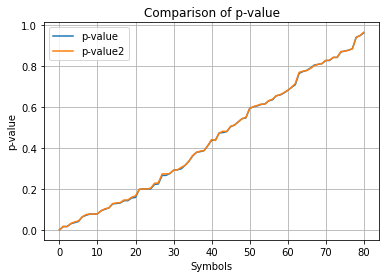

In [89]:
pos_neg['p-value'] = pos_neg['p-value'].astype(float)
pos_neg['p-value2'] = pos_neg['p-value2'].astype(float)

# sort dataframe by p-value
pos_neg = pos_neg.sort_values(by=['p-value'], ascending=True, ignore_index=True)

plt.plot(pos_neg['p-value'], label='p-value')
plt.plot(pos_neg['p-value2'], label='p-value2')
plt.xlabel('Symbols')
plt.ylabel('p-value')
plt.title('Comparison of p-value')
plt.legend()
plt.grid()
plt.show()

# Export plot as png file
plt.savefig('../output/comparison.png', dpi=300, bbox_inches='tight')

## Finalized

In [86]:
t = np.random.choice(11, 10, replace=False)
t

array([ 4, 10,  2,  8,  0,  6,  1,  7,  5,  9])